In [1]:
import pandas as pd
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import math


In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
%matplotlib inline

In [5]:
def readFile(filename):
    print("======DC: Total Personal Income File=====")
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [62]:
df_Income = readFile("DC_TotalPersonalIncome.csv")

======DC: Total Personal Income File=====
File read into dataframe.
(39, 1)


In [63]:
df_Income.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [64]:
df_Income.head()

,DC_Total Personal Income
1977-01-01,7032.5
1978-01-01,7490.9
1979-01-01,7905.3
1980-01-01,8355.1
1981-01-01,8971.2


In [65]:
df_Income.rename(columns={'DC_Total Personal Income': 'DC_TotalPersonalIncome'}, inplace=True)

In [66]:
df_Income.DC_TotalPersonalIncome.describe()

count       39.000000
mean     22895.828205
std      12381.243029
min       7032.500000
25%      12457.250000
50%      19195.400000
75%      31757.400000
max      48070.300000
Name: DC_TotalPersonalIncome, dtype: float64

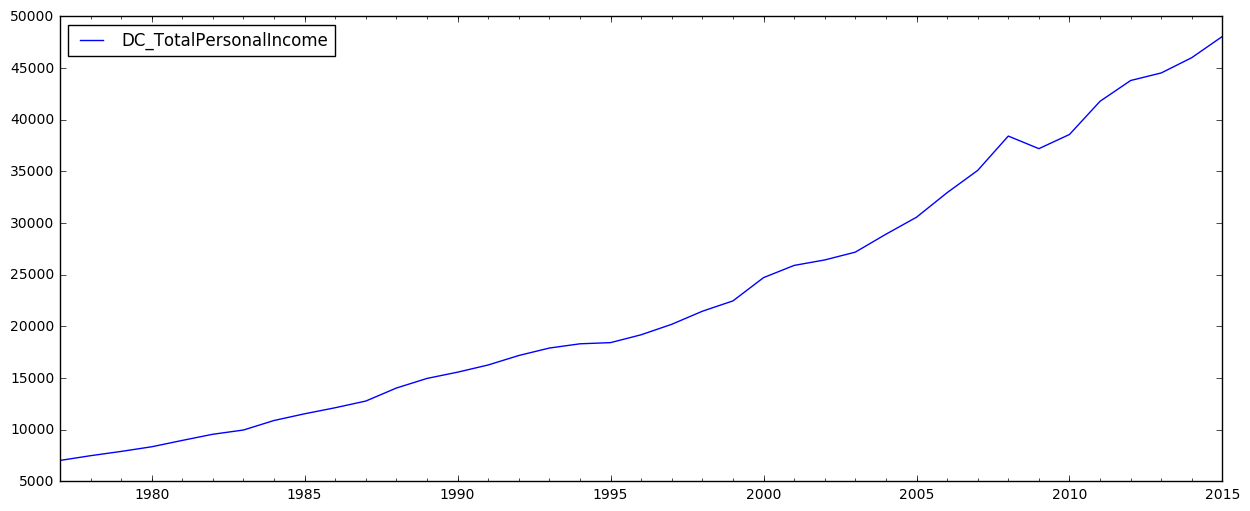

In [67]:
df_Income.plot(figsize=(15,6))
plt.show()
#fig.savefig('DC_TotalPersonalIncome.png', dpi=150)

There is an overall increasing trend in the data.

In [68]:
#Further Decompose time-series into trend, seasionality and noise
def decompose(df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')
    fig = decomposition.plot()
    plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

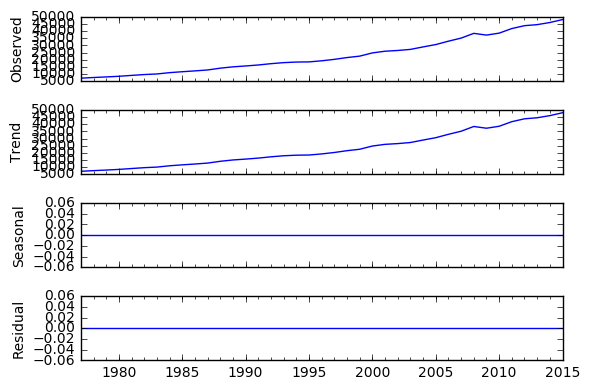

In [69]:
decompose(df_Income)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not.
First, check the mean and variance.
Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [70]:
#Split the dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [71]:
meanVarianceCheck(df_Income)

('mean1=12598.652632, mean2=32678.145000',
 'variance1=14563016.760388, variance2=81002018.645475')

In [72]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

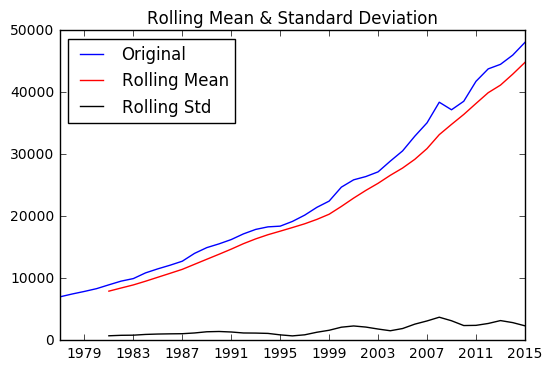

Results of Dickey-Fuller Test:
Test Statistic                  1.055964
p-value                         0.994823
#Lags Used                     10.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [73]:
test_stationarity(df_Income.DC_TotalPersonalIncome)

# Estimating & Eliminating Trend

In [74]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

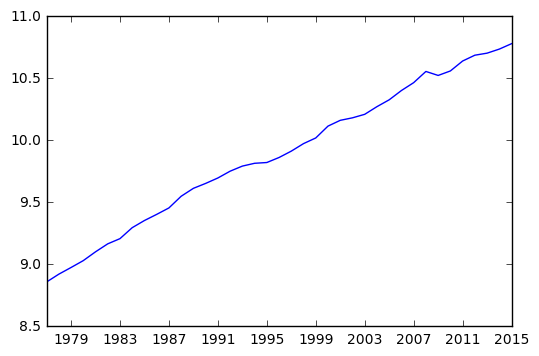

In [75]:
ts_log = logTransform(df_Income)

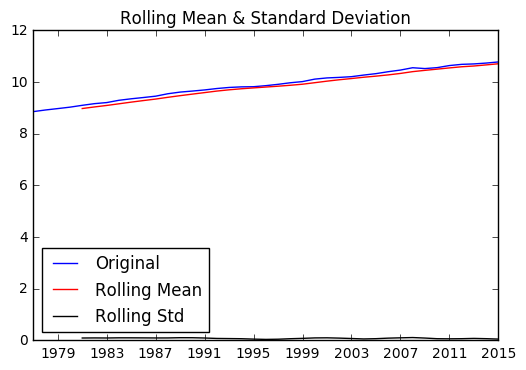

Results of Dickey-Fuller Test:
Test Statistic                 -1.727526
p-value                         0.416989
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [76]:
test_stationarity(ts_log.DC_TotalPersonalIncome)

In [77]:
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

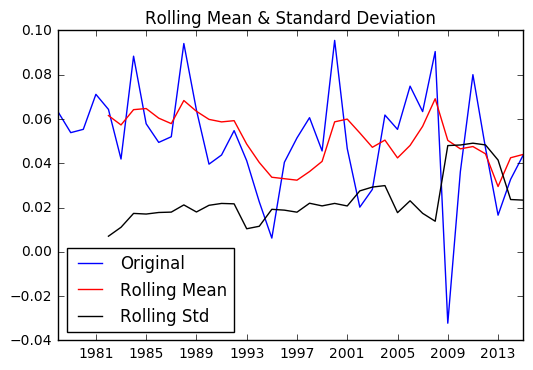

Results of Dickey-Fuller Test:
Test Statistic                 -4.742868
p-value                         0.000070
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [78]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.DC_TotalPersonalIncome)

In [79]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

In [80]:
ts_first_diff = firstDifference(df_Income)

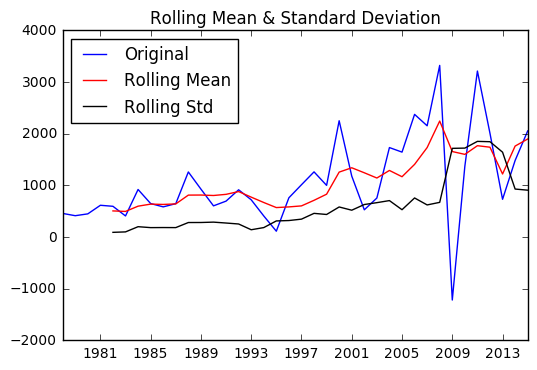

Results of Dickey-Fuller Test:
Test Statistic                 -0.543896
p-value                         0.883162
#Lags Used                     10.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


In [81]:
test_stationarity(ts_first_diff.DC_TotalPersonalIncome)

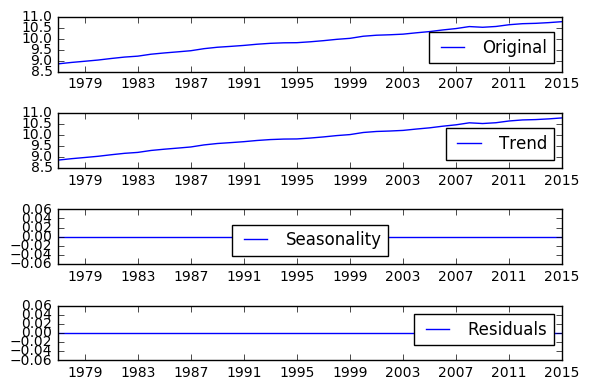

In [82]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

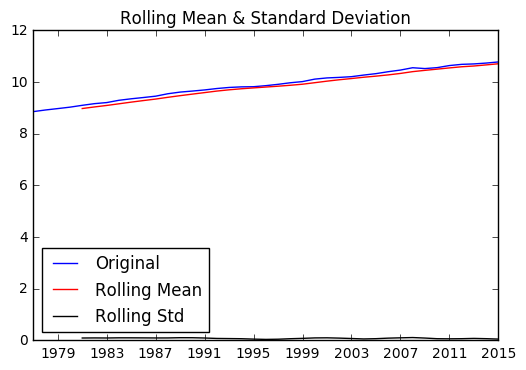

Results of Dickey-Fuller Test:
Test Statistic                 -1.727526
p-value                         0.416989
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [83]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.DC_TotalPersonalIncome)

# Forecasting a Time Series

In [84]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

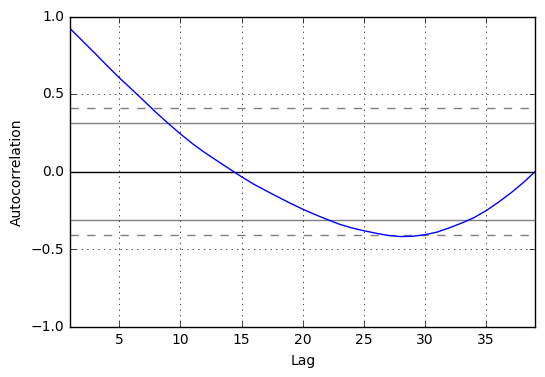

In [86]:
#Plot ACF: 
autocorrelation_plot(ts_log)

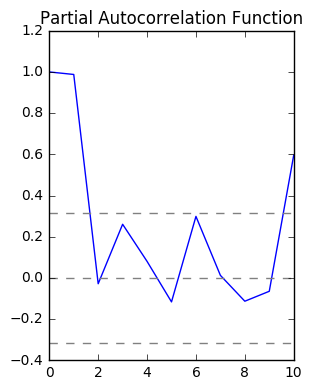

In [87]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [88]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [89]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [90]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2,0, 0))
    results_AR = model.fit(disp=-1)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    print(results_AR.fittedvalues)
    return results_AR

Lag: 2
Coefficients: const                           9.801959
ar.L1.DC_TotalPersonalIncome    1.815141
ar.L2.DC_TotalPersonalIncome   -0.818085
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     DC_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(2, 0)   Log Likelihood                  74.833
Method:                           css-mle   S.D. of innovations              0.032
Date:                    Thu, 27 Apr 2017   AIC                           -141.666
Time:                            16:45:52   BIC                           -135.012
Sample:                        01-01-1977   HQIC                          -139.279
                             - 01-01-2015                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

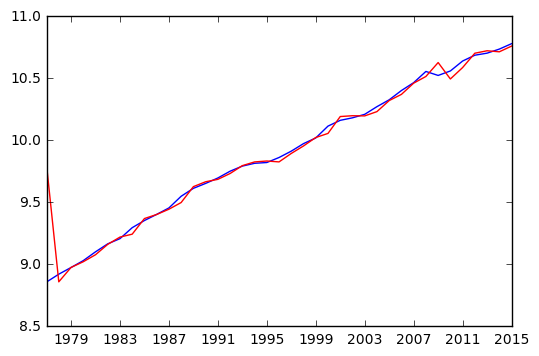

In [91]:
model_AR = AR_Model(ts_log)

In [92]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 1))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 1))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                           9.881460
ma.L1.DC_TotalPersonalIncome    0.999976
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     DC_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(0, 1)   Log Likelihood                  -9.860
Method:                           css-mle   S.D. of innovations              0.297
Date:                    Thu, 27 Apr 2017   AIC                             25.721
Time:                            16:45:57   BIC                             30.711
Sample:                        01-01-1977   HQIC                            27.511
                             - 01-01-2015                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                   

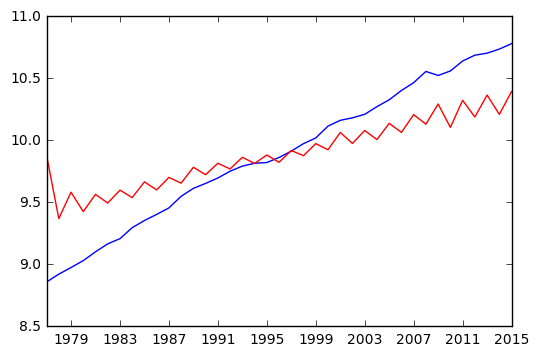

In [93]:
model_MA = MA_Model(ts_log)

In [100]:
def Combined_Model(ts):
    model = ARIMA(ts, order=(5, 0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(5, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 5
Coefficients: const                           9.478033
ar.L1.DC_TotalPersonalIncome    0.664065
ar.L2.DC_TotalPersonalIncome    0.715844
ar.L3.DC_TotalPersonalIncome   -0.118434
ar.L4.DC_TotalPersonalIncome    0.276650
ar.L5.DC_TotalPersonalIncome   -0.553136
ma.L1.DC_TotalPersonalIncome    0.997676
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     DC_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(5, 1)   Log Likelihood                  80.794
Method:                           css-mle   S.D. of innovations              0.025
Date:                    Thu, 27 Apr 2017   AIC                           -145.587
Time:                            16:46:47   BIC                           -132.279
Sample:                        01-01-1977   HQIC                          -140.812
                             - 01-01-2015                                         
             

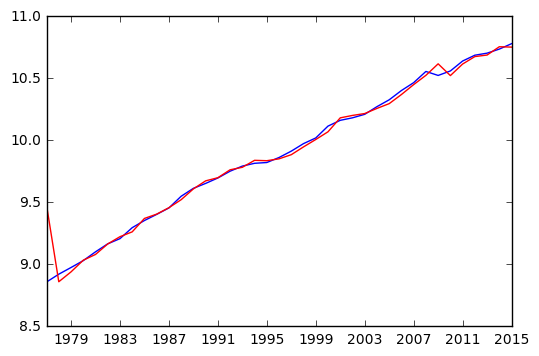

In [101]:
model_combined = Combined_Model(ts_log)

In [102]:
aic_metric

,AIC,Modelname
0,-141.666221,"ARIMA(ts, order=(2, 0, 0))"
0,25.720695,"ARIMA(ts, order=(0, 0, 1))"
0,-145.587293,"ARIMA(ts, order=(5, 0, 1))"


In [103]:
aic_dict

{'ARIMA(ts, order=(0, 0, 1))': 25.72069526798562,
 'ARIMA(ts, order=(2, 0, 0))': -141.66622111509136,
 'ARIMA(ts, order=(5, 0, 1))': -145.58729272718105}

In [104]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(5, 0, 1))


In [105]:
#Forcast using Best Model
def forcast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=5)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output

In [107]:
output_forcast = forcast(model_AR,5)

[ 49675.68686983  50877.10590604  51723.65561555  52264.58119334
  52546.73016898]
